In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, mannwhitneyu

from sklearn.datasets import make_classification

In [2]:
def evaluate_groups(df, target_col='target', value_col='gross_summ', n_iter=100, bootstrap_size = None, plot=True):
    tr_values = df[df[target_col] == 1][value_col].values
    co_values = df[df[target_col] == 0][value_col].values

    if not bootstrap_size:
        bootstrap_size = int(len(df) / 10)

    diffs = []
    for _ in range(n_iter):
        tr_sample = np.random.choice(tr_values, size=bootstrap_size, replace=True)
        co_sample = np.random.choice(co_values, size=bootstrap_size, replace=True)
        diff = tr_sample.mean() - co_sample.mean()
        diffs.append(diff)

    mean_diff = np.mean(diffs)
    ci_lower = np.percentile(diffs, 2.5)
    ci_upper = np.percentile(diffs, 97.5)

    result = {
        'Metric/Field': value_col,
        'Mean Difference': round(mean_diff, 3),
        'CI Lower': round(ci_lower, 3),
        'CI Upper': round(ci_upper, 3),
        'T-test p-value': round(ttest_ind(tr_values, co_values).pvalue, 3),
        'Mann-Whitney p-value': round(mannwhitneyu(tr_values, co_values).pvalue, 3)
    }
    result = pd.DataFrame(result, index =[0]).T.round(3)

    if plot:
        plt.figure(figsize=(8, 4))
        plt.hist(diffs, bins=20, color='skyblue', edgecolor='black')
        plt.axvline(mean_diff, color='red', linestyle='--', label=f'Mean diff: {mean_diff:.2f}')
        plt.axvline(ci_lower, color='green', linestyle=':', label='95% CI lower')
        plt.axvline(ci_upper, color='green', linestyle=':', label='95% CI upper')
        plt.title(f'Bootstrap distribution of mean diff ({value_col})')
        plt.xlabel('Difference')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return result


In [3]:
X, y = make_classification(
    n_samples=10000,
    n_features=4,
    n_informative=4,
    n_redundant=0,
    n_clusters_per_class=4,
    random_state=42
)

df_fake = pd.DataFrame({
    'user_id': np.random.randint(1, 200, size=10000),
    'gross_summ': np.abs(X[:, 0] * 100 + np.random.normal(0, 10, size=10000)),
    'target': y
})
df_fake.head()

,user_id,gross_summ,target
0,84,89.568824,0
1,24,64.394495,0
2,40,73.270411,1
3,123,70.674383,0
4,2,147.812298,1


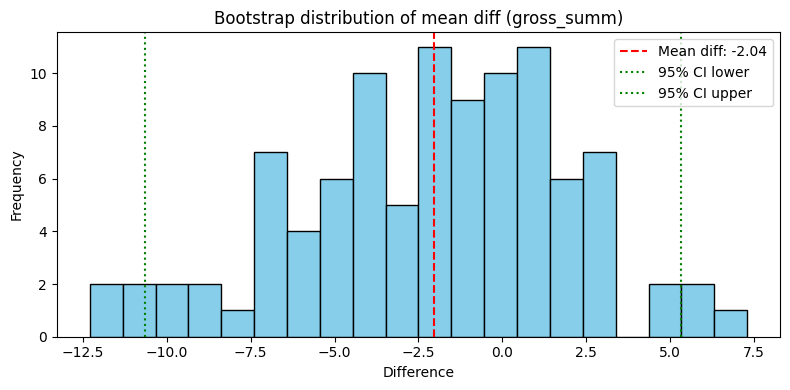

,0
Metric/Field,gross_summ
Mean Difference,-2.035
CI Lower,-10.64
CI Upper,5.315
T-test p-value,0.107
Mann-Whitney p-value,0.207


In [4]:
evaluate_groups(df_fake)